# Explorative Datenanalyse (EDA)

Dieses Notebook untersucht das bereinigte Trainings- und Test-Set, um Muster für das Kredit-Scoring aufzudecken. Die Analysen zielen darauf ab, Hypothese H1 (klassische ML-Modelle sind auf tabellare Daten ebenso stark wie komplexe generative Modelle) und H2 (generative Modelle benötigen für tabellarische Probleme unverhältnismäßig viele Ressourcen) empirisch vorzubereiten.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
train = pd.read_csv("../data/train_cleaned.csv")
test = pd.read_csv("../data/test_cleaned.csv")

print(f'Trainingsdaten: {train.shape[0]:,} Zeilen, {train.shape[1]} Spalten')
print(f'Testdaten: {test.shape[0]:,} Zeilen, {test.shape[1]} Spalten')

Trainingsdaten: 100,000 Zeilen, 28 Spalten
Testdaten: 50,000 Zeilen, 27 Spalten


## 1️⃣ Erster Überblick

Die Stichprobe zeigt die wichtigsten Felder für Kreditwürdigkeit (Einkommen, Schulden, Zahlungs- und Historienmerkmale). Die Zielvariable `Credit_Score` bleibt dreistufig.


In [3]:
display(train.head(3))

target_counts = train['Credit_Score'].value_counts().rename_axis('Credit_Score').reset_index(name='Anzahl')
target_counts['Anteil_%'] = (target_counts['Anzahl'] / target_counts['Anzahl'].sum() * 100).round(2)
display(target_counts)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,"19,114.12","1,824.84",3,...,Unknown,809.98,26.82,22.10,No,49.60,80.42,High Spent Small Value Payments,312.49,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,"19,114.12","1,592.84",3,...,Good,809.98,31.94,0.00,No,49.60,118.28,Low Spent Large Value Payments,284.63,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,16,821-00-0265,Scientist,"19,114.12","1,592.84",3,...,Good,809.98,28.61,22.20,No,49.60,81.70,Low Spent Medium Value Payments,331.21,Good


,Credit_Score,Anzahl,Anteil_%
0,Standard,53174,53.17
1,Poor,28998,29.00
2,Good,17828,17.83


In [4]:
train.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

,mean,std,min,25%,50%,75%,max
Age,32.88,10.94,16.00,24.00,32.00,41.00,99.00
Annual_Income,"176,415.70","1,429,618.05","7,005.93","19,457.50","37,578.61","72,790.92","24,198,062.00"
Monthly_Inhand_Salary,"5,743.26","45,814.69",303.65,"1,625.79","3,101.37","5,971.78","1,990,379.58"
Num_Bank_Accounts,5.37,2.96,0.00,3.00,5.00,7.00,99.00
Num_Credit_Card,5.56,2.98,0.00,4.00,5.00,7.00,99.00
Interest_Rate,14.32,8.85,1.00,7.00,13.00,20.00,99.00
Num_of_Loan,3.45,2.65,0.00,1.00,3.00,5.00,95.00
Delay_from_due_date,21.10,14.82,0.00,10.00,18.00,28.00,67.00
Num_of_Delayed_Payment,13.31,6.13,0.00,9.00,14.00,18.00,98.00
Changed_Credit_Limit,10.17,6.88,-6.49,4.97,9.25,14.66,36.97


## 2️⃣ Datenqualität

Prüfung auf fehlende Werte und Dubletten stellt sicher, dass spätere Modellvergleiche nicht durch Datenlücken verzerrt werden.


In [5]:
missing = train.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]

print(f'Dubletten (komplett identische Zeilen): {train.duplicated().sum():,}')
missing.to_frame('Anzahl fehlend')

Dubletten (komplett identische Zeilen): 0


,Anzahl fehlend
Type_of_Loan,11408
SSN,5572


## 3️⃣ Feature-Typen

Numerische und kategoriale Felder werden getrennt betrachtet, um zielgerichtete Visualisierungen zu erstellen.


In [6]:
numeric_cols = train.select_dtypes(include='number').columns.tolist()
categorical_cols = train.select_dtypes(exclude='number').columns.tolist()

print(f'Numerische Features: {len(numeric_cols)}')
display(numeric_cols)
print(f'Kategoriale/ID-Features: {len(categorical_cols)}')
display(categorical_cols)

Numerische Features: 17


['Age',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance']

Kategoriale/ID-Features: 11


['ID',
 'Customer_ID',
 'Month',
 'Name',
 'SSN',
 'Occupation',
 'Type_of_Loan',
 'Credit_Mix',
 'Payment_of_Min_Amount',
 'Payment_Behaviour',
 'Credit_Score']

## 4️⃣ Deskriptive Kennzahlen nach Zielvariable

Durchschnittswerte pro `Credit_Score`-Gruppe verdeutlichen frühe Muster.


In [7]:
group_summary = train.groupby('Credit_Score')[numeric_cols].agg(['mean', 'median', 'std']).T
group_summary.head(len(numeric_cols))

Credit_Score                         Good         Poor     Standard
Age                   mean          35.80        30.85        33.01
                      median        36.00        30.00        32.00
                      std           11.49        10.05        10.98
Annual_Income         mean     184,936.59   154,979.03   185,249.16
                      median    45,536.43    32,276.42    37,201.06
                      std    1,409,982.81 1,368,526.18 1,468,143.76
Monthly_Inhand_Salary mean       7,166.62     4,731.83     5,817.61
                      median     3,824.74     2,677.97     3,102.12
                      std       49,262.72    44,271.19    45,428.41
Num_Bank_Accounts     mean           3.47         6.52         5.38
                      median         3.00         7.00         5.00
                      std            2.68         2.94         2.73
Num_Credit_Card       mean           4.20         6.62         5.44
                      median         4.00         6.00         5.00
                      std            2.82         2.94         2.84
Interest_Rate         mean           7.59        19.85        13.56
                      median         7.00        21.00        12.00

## 5️⃣ Univariate Verteilungen – numerische Features

Wichtige Finanz- und Kreditmerkmale werden hinsichtlich ihrer Verteilung analysiert, um Ausreißer und Schiefen zu erkennen.


In [8]:
def plot_histograms(df, columns, bins=40):
    columns = [col for col in columns if col in df.columns]
    for start in range(0, len(columns), 3):
        subset = columns[start:start + 3]
        fig, axes = plt.subplots(1, len(subset), figsize=(6 * len(subset), 4))
        if len(subset) == 1:
            axes = [axes]
        for ax, col in zip(axes, subset):
            sns.histplot(data=df, x=col, bins=bins, kde=True, ax=ax, color='#1f77b4')
            ax.set_title(col.replace('_', ' '))
        plt.tight_layout()

In [9]:
financial_cols = ['Annual_Income', 'Monthly_Inhand_Salary', 'Monthly_Balance', 'Amount_invested_monthly', 'Total_EMI_per_month']
credit_usage_cols = ['Outstanding_Debt', 'Credit_Utilization_Ratio', 'Num_of_Loan', 'Interest_Rate', 'Num_Credit_Inquiries']
behaviour_cols = ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit']

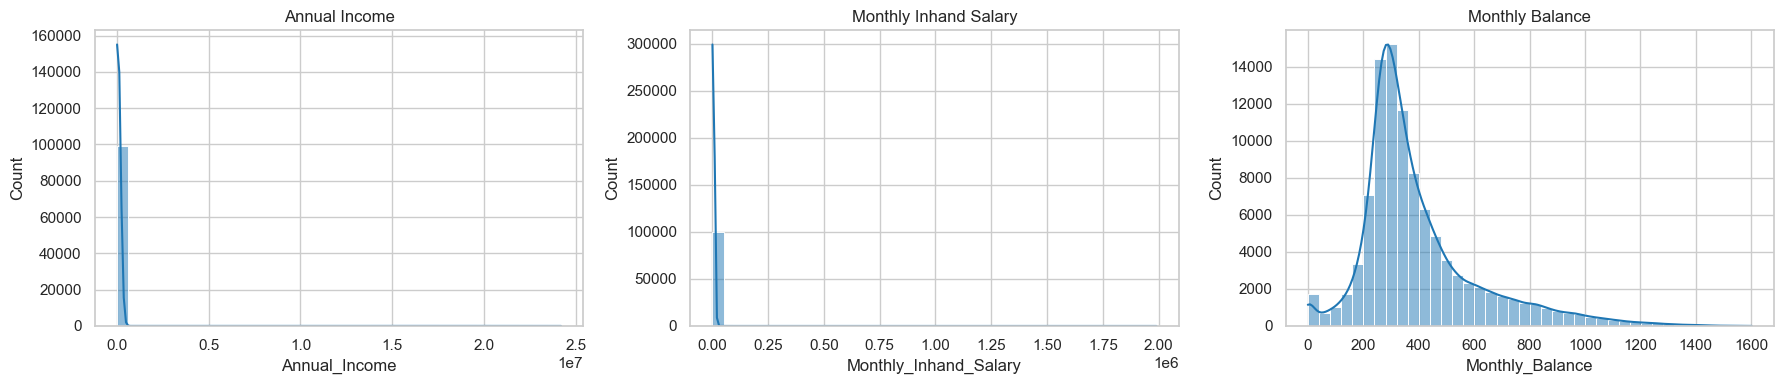

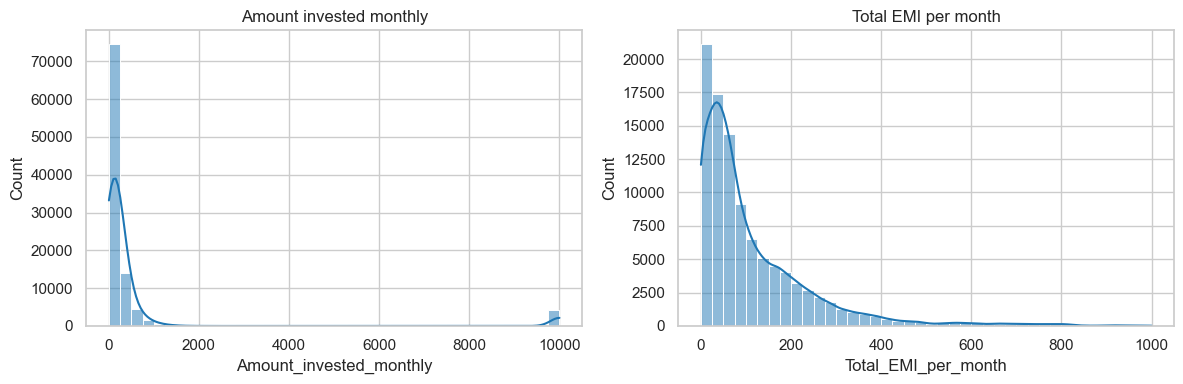

In [10]:
plot_histograms(train, financial_cols)

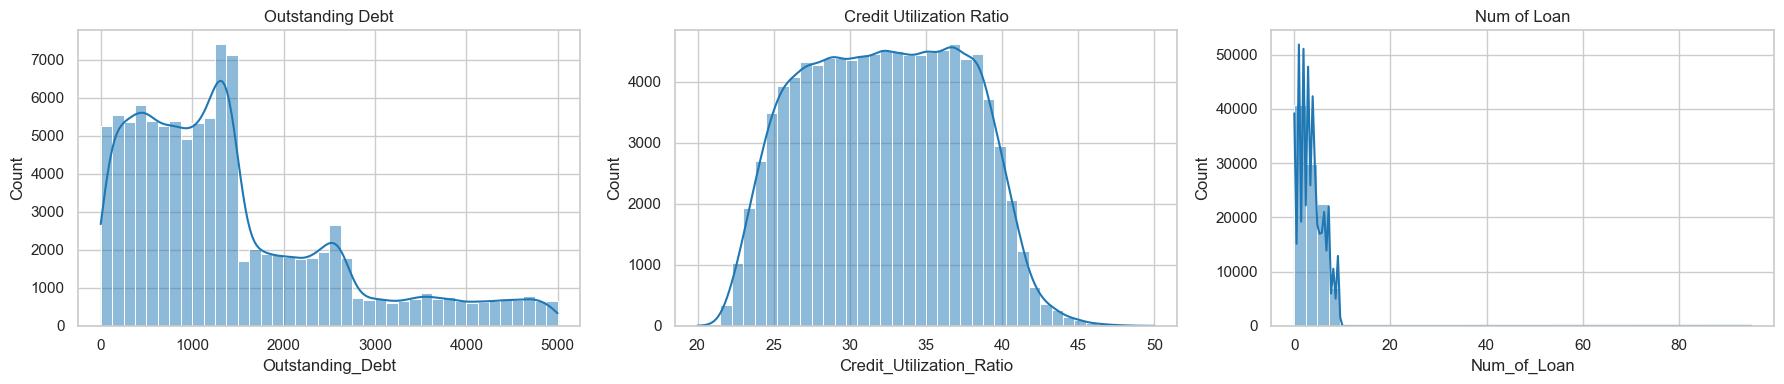

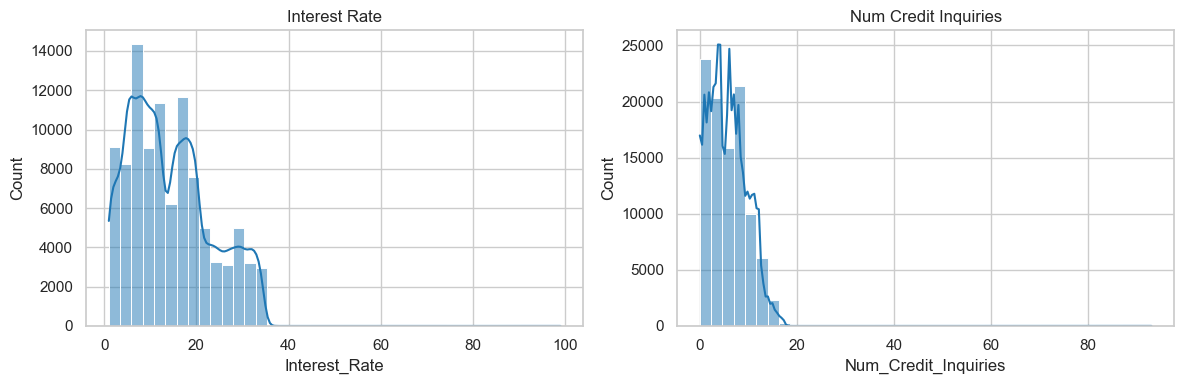

In [11]:
plot_histograms(train, credit_usage_cols)

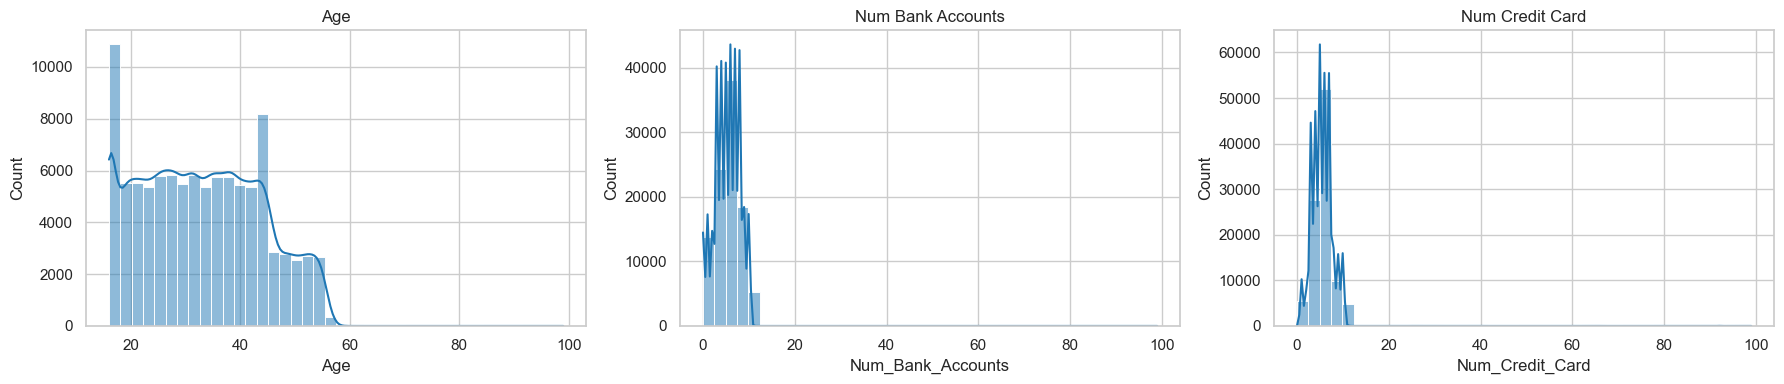

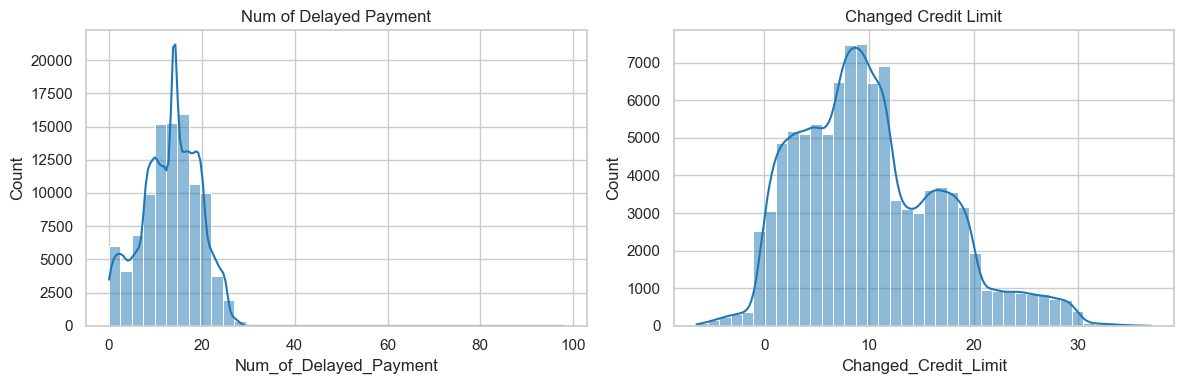

In [12]:
plot_histograms(train, behaviour_cols)

## 6️⃣ Univariate Verteilungen – kategoriale Features

Fokus auf Merkmale, die sich für Modellentscheidungen eignen (IDs werden ausgelassen).


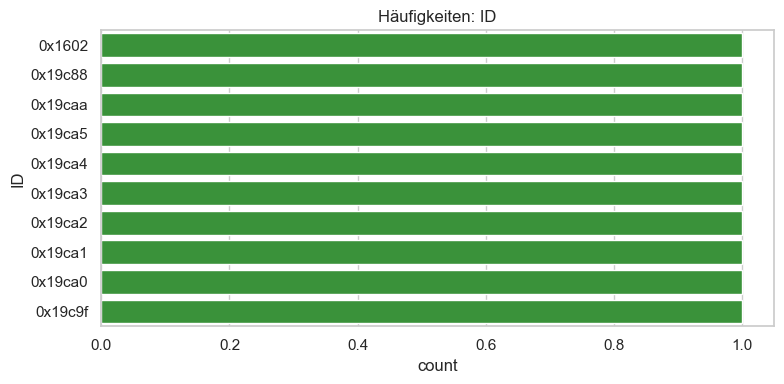

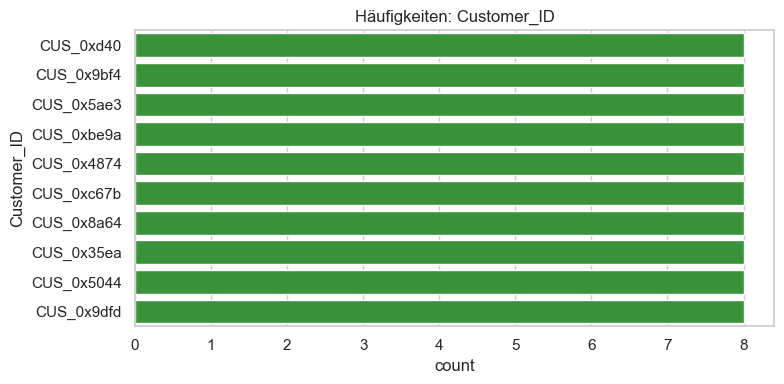

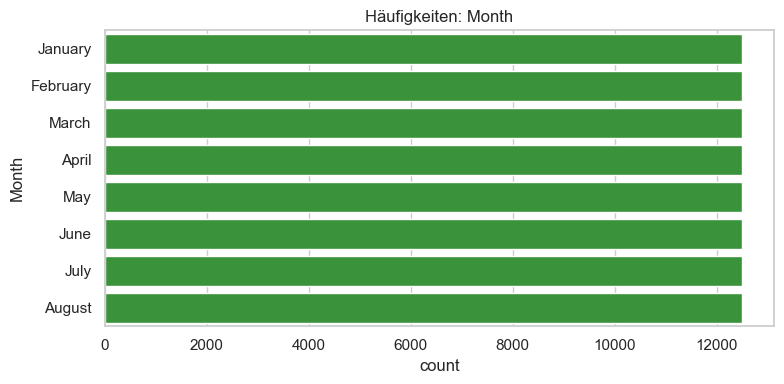

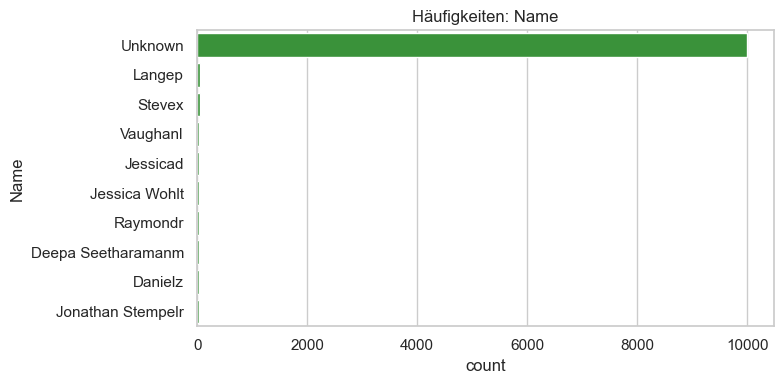

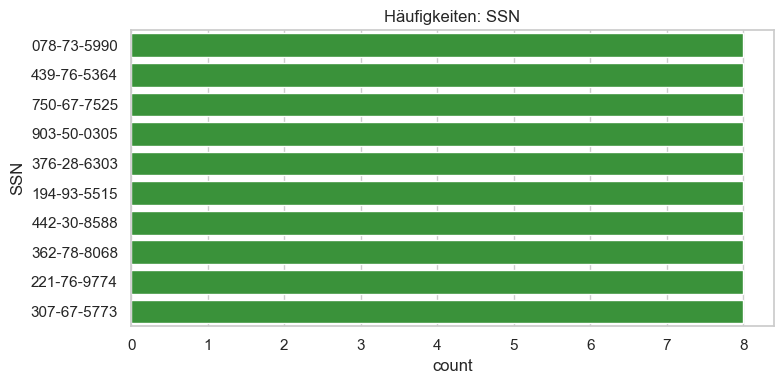

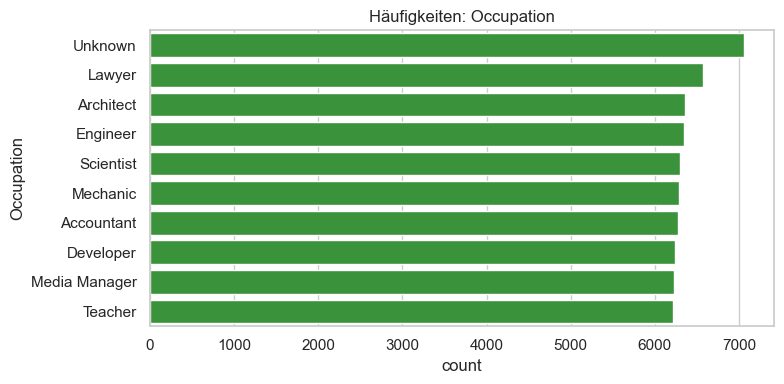

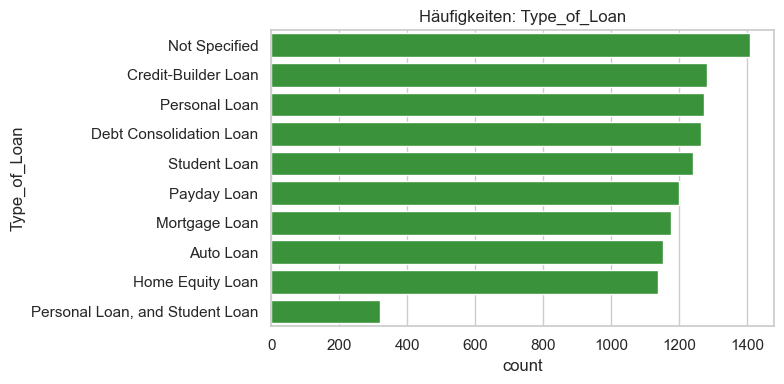

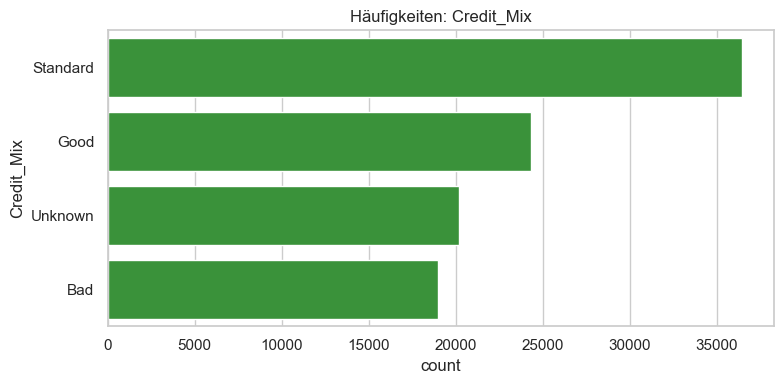

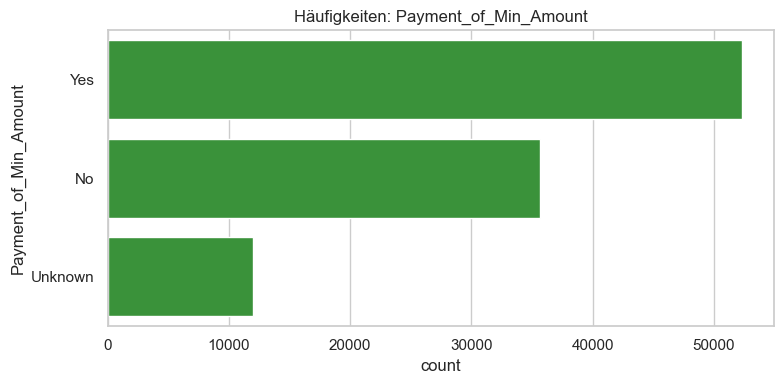

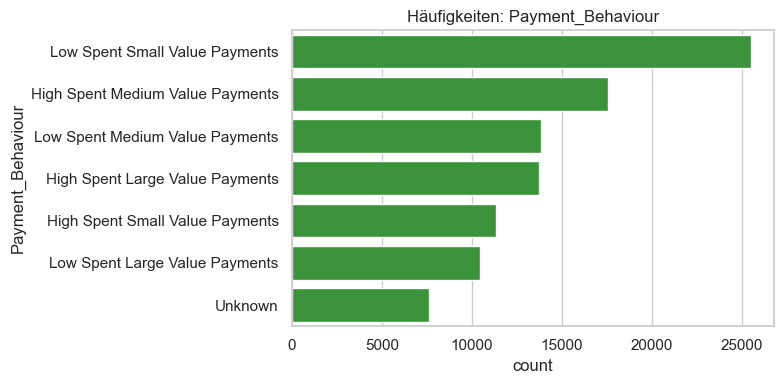

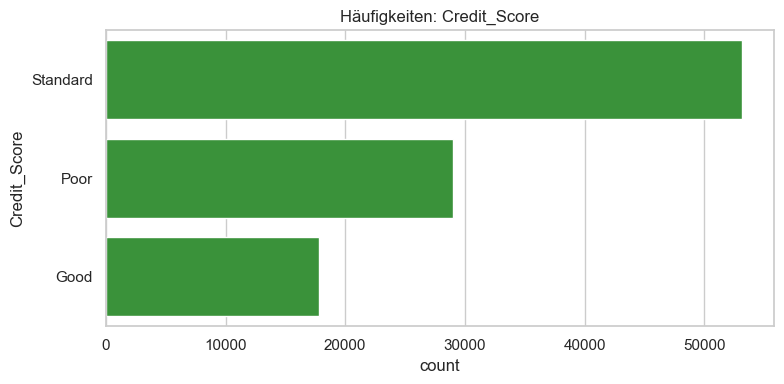

In [13]:
def plot_categorical_counts(df, column, top_n=10):
    order = df[column].value_counts().head(top_n).index
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df[df[column].isin(order)], y=column, order=order, color='#2ca02c')
    plt.title(f'Häufigkeiten: {column}')
    plt.tight_layout()

for col in categorical_cols:
    plot_categorical_counts(train, col)

## 7️⃣ Ausreißeranalyse (IQR-Regel)

Extremwerte können Modelle verzerren. Wir prüfen kritische Finanzmerkmale mit der IQR-Regel und erzeugen eine Version ohne Ausreißer.

In [14]:
def identify_outliers_iqr(df, columns, factor=1.5):
    summary = []
    combined_mask = pd.Series(False, index=df.index)
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        mask = (df[col] < lower) | (df[col] > upper)
        combined_mask |= mask
        summary.append({
            'Feature': col,
            'Lower_Bound': lower,
            'Upper_Bound': upper,
            'Outlier_Count': int(mask.sum()),
            'Outlier_%': round(mask.mean() * 100, 2)
        })
    trimmed_df = df.loc[~combined_mask].copy()
    return pd.DataFrame(summary).sort_values('Outlier_%', ascending=False), trimmed_df, combined_mask.sum()

In [15]:
iqr_features = ['Annual_Income',
                'Monthly_Inhand_Salary',
                'Outstanding_Debt',
                'Credit_Utilization_Ratio',
                'Total_EMI_per_month',
                'Amount_invested_monthly',
                'Monthly_Balance']

outlier_summary, train_no_outliers, total_outliers = identify_outliers_iqr(train, iqr_features)

In [16]:
print(f'Ausreißer über alle betrachteten Features: {total_outliers:,} ({total_outliers / len(train) * 100:.2f}%)')
display(outlier_summary)
train_no_outliers.head(3)

Ausreißer über alle betrachteten Features: 27,122 (27.12%)


,Feature,Lower_Bound,Upper_Bound,Outlier_Count,Outlier_%
5,Amount_invested_monthly,-213.98,536.45,10495,10.50
6,Monthly_Balance,-31.83,767.37,7717,7.72
4,Total_EMI_per_month,-160.80,348.80,5775,5.78
2,Outstanding_Debt,"-1,503.76","4,015.80",5272,5.27
0,Annual_Income,"-60,542.63","152,791.05",2783,2.78
1,Monthly_Inhand_Salary,"-4,893.19","12,490.76",2141,2.14
3,Credit_Utilization_Ratio,15.39,49.16,4,0.00


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,"19,114.12","1,824.84",3,...,Unknown,809.98,26.82,22.10,No,49.60,80.42,High Spent Small Value Payments,312.49,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,"19,114.12","1,592.84",3,...,Good,809.98,31.94,0.00,No,49.60,118.28,Low Spent Large Value Payments,284.63,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,16,821-00-0265,Scientist,"19,114.12","1,592.84",3,...,Good,809.98,28.61,22.20,No,49.60,81.70,Low Spent Medium Value Payments,331.21,Good


### Bereinigter Trainingssatz speichern

Der ausreißerbereinigte Trainingssatz wird als `train_eda.csv` für nachfolgende Modellierungsschritte abgelegt.


In [17]:
train_no_outliers.to_csv("../data/train_eda.csv", index=False)
print(f'Gespeicherte Zeilen (ohne Ausreißer): {len(train_no_outliers):,}')

Gespeicherte Zeilen (ohne Ausreißer): 72,878


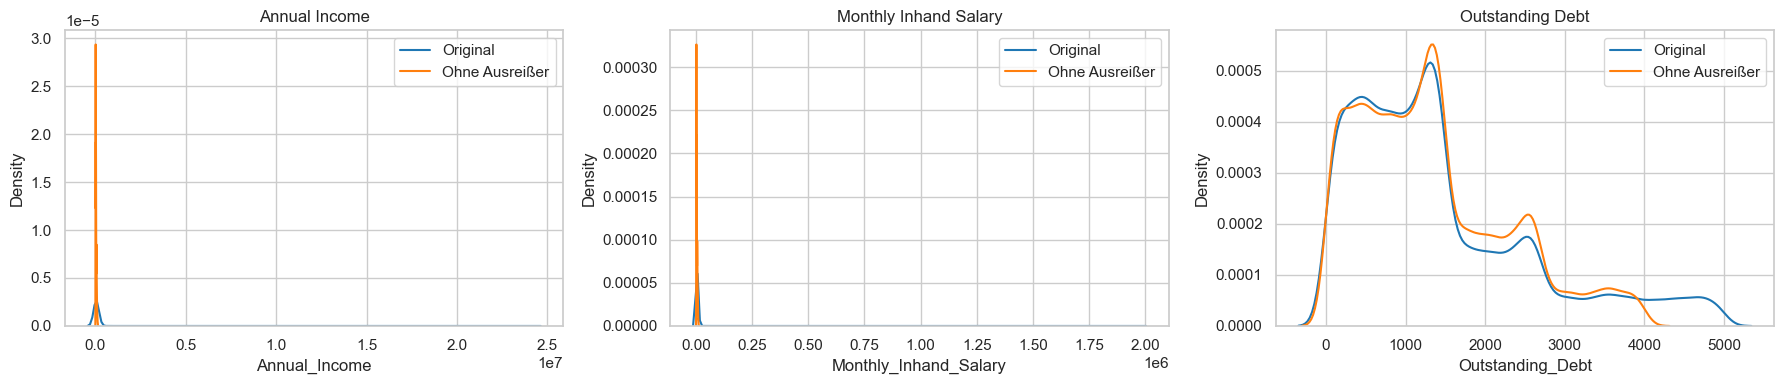

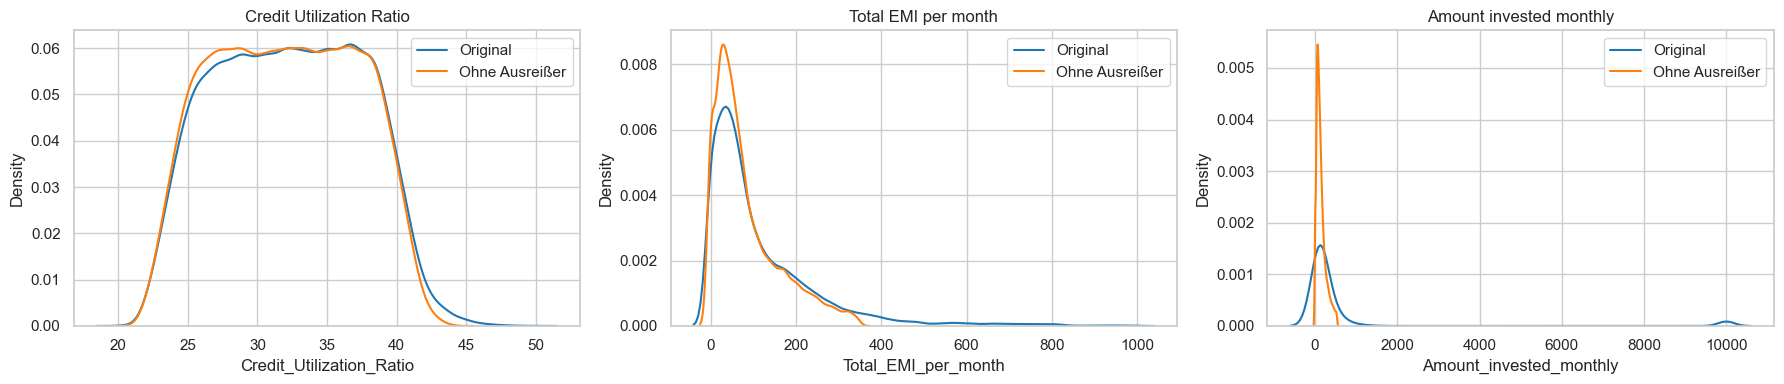

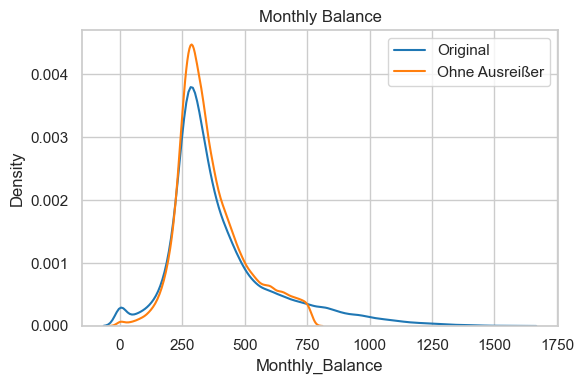

In [18]:
def plot_outlier_effect(original, trimmed, columns):
    for start in range(0, len(columns), 3):
        subset = columns[start:start + 3]
        fig, axes = plt.subplots(1, len(subset), figsize=(6 * len(subset), 4))
        if len(subset) == 1:
            axes = [axes]
        for ax, col in zip(axes, subset):
            sns.kdeplot(data=original, x=col, ax=ax, label='Original', color='#1f77b4')
            sns.kdeplot(data=trimmed, x=col, ax=ax, label='Ohne Ausreißer', color='#ff7f0e')
            ax.set_title(col.replace('_', ' '))
            ax.legend()
        plt.tight_layout()

plot_outlier_effect(train, train_no_outliers, iqr_features)

## 8️⃣ Zielvariable vs. numerische Prädiktoren

Wir betrachten, welche numerischen Features starke Unterschiede zwischen den Credit-Score-Klassen aufweisen (Ausreißer-bereinigte Daten).


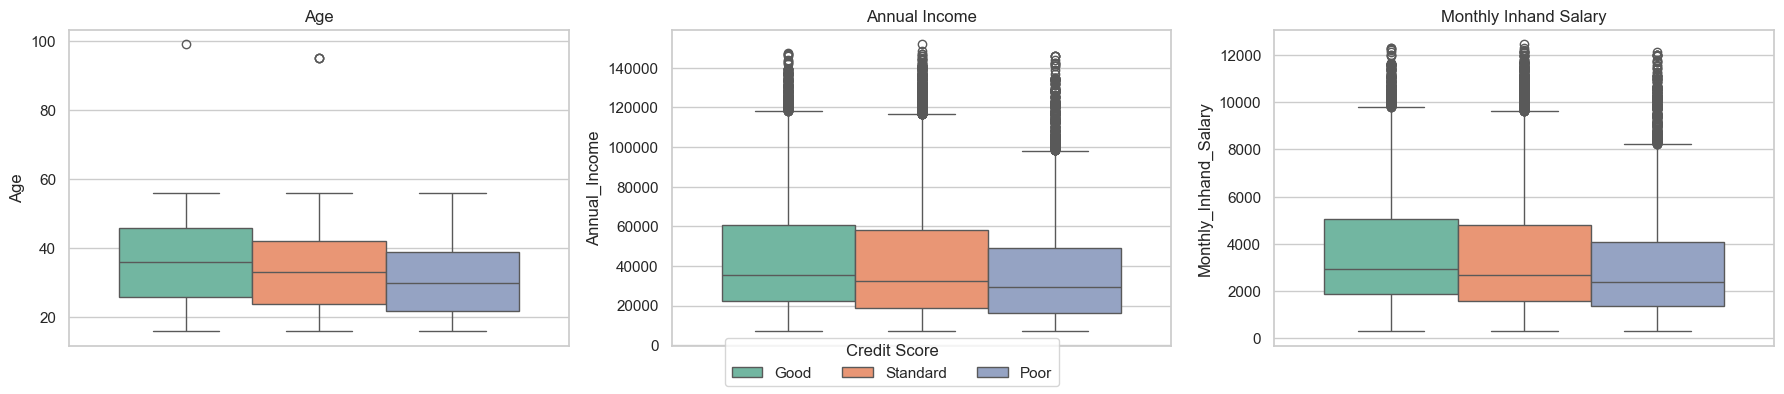

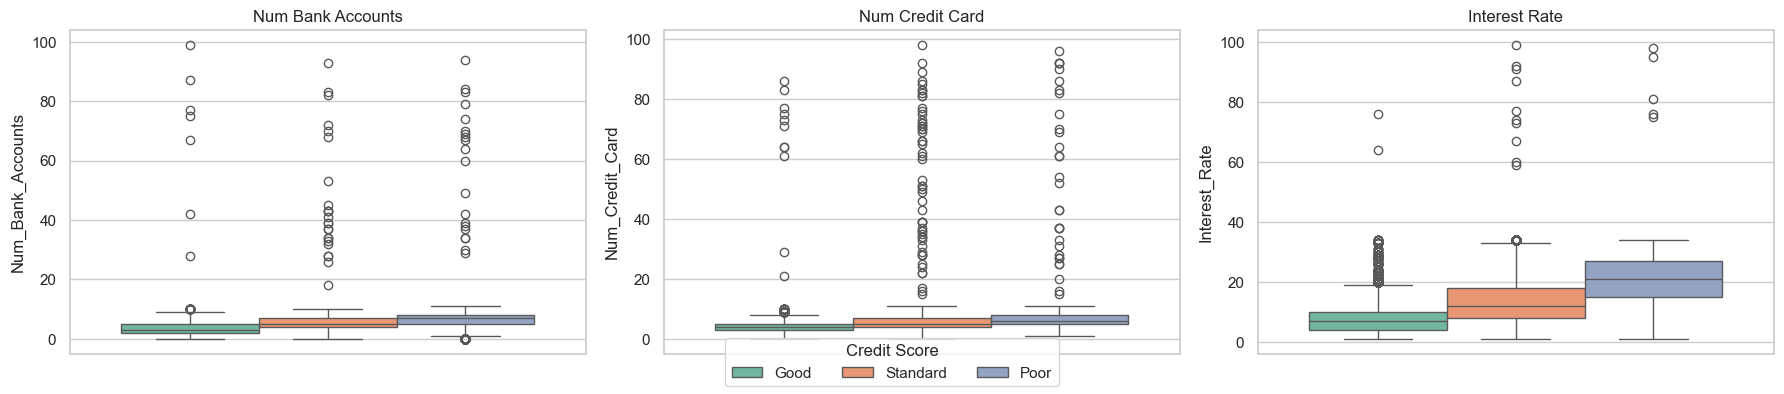

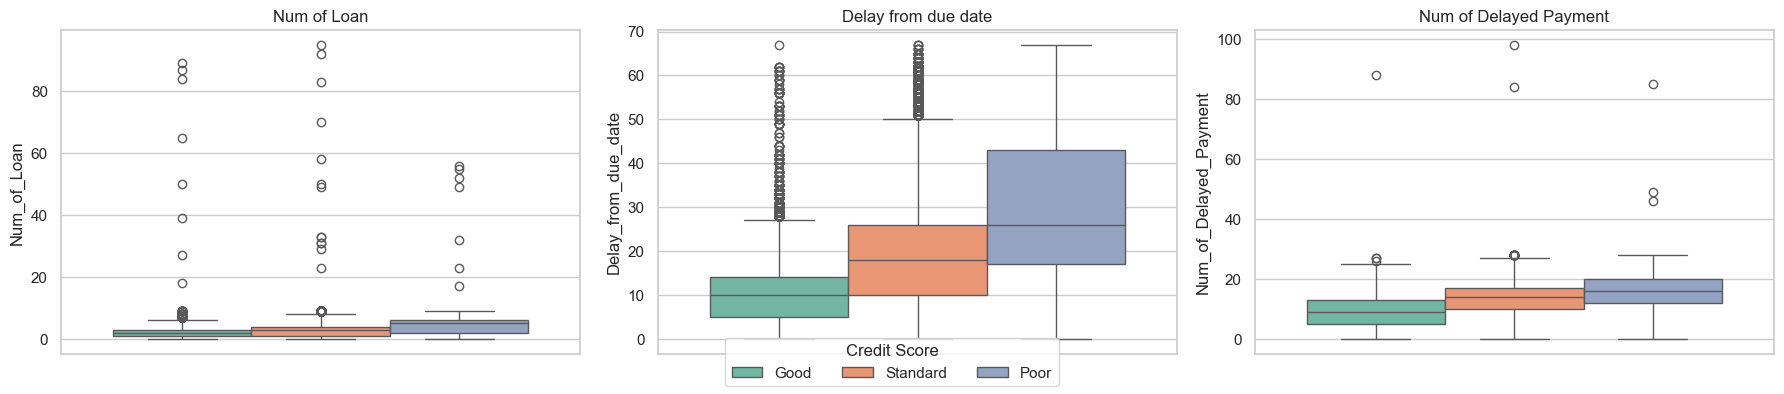

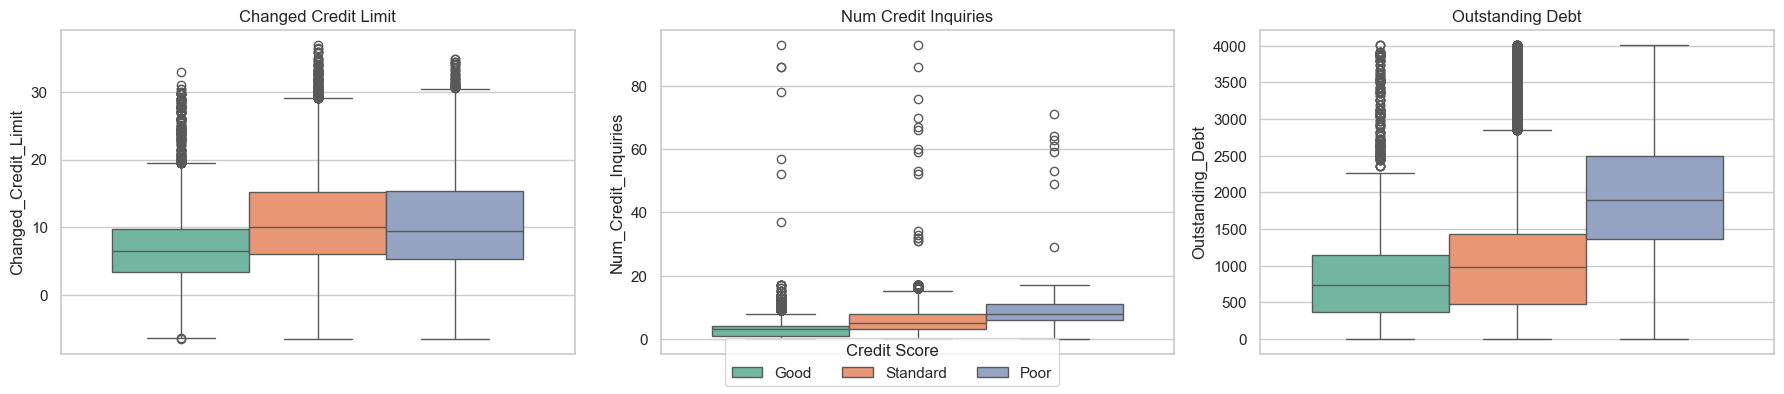

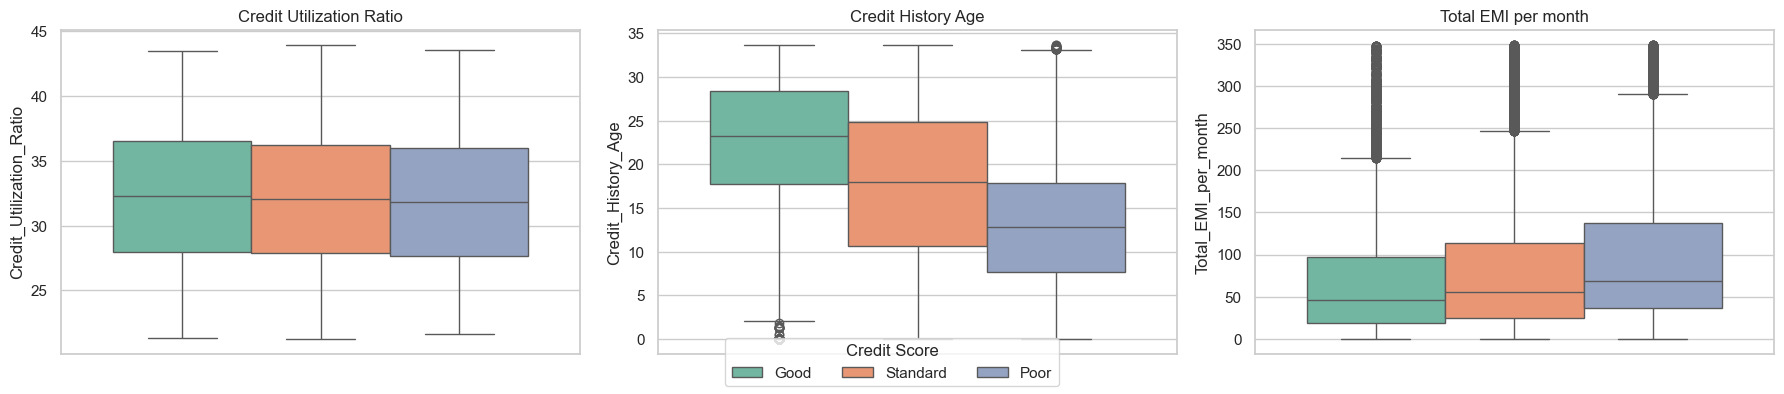

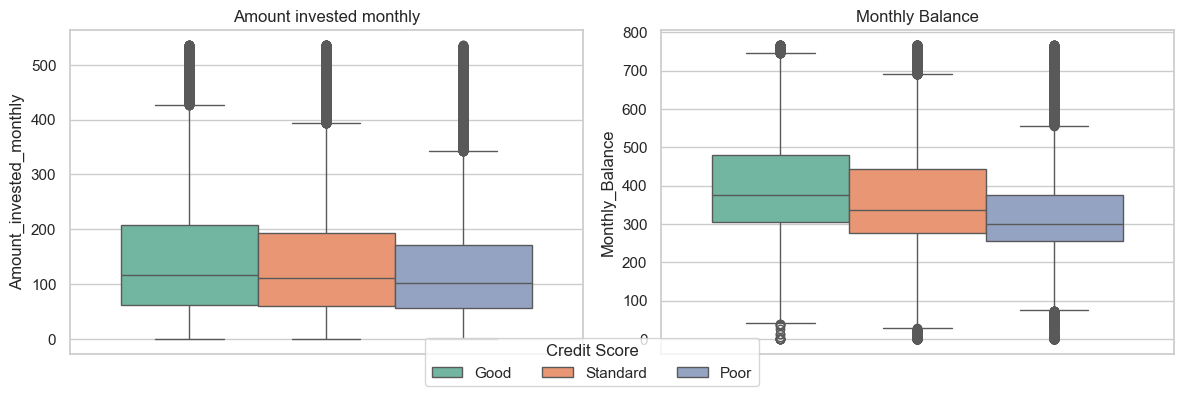

In [19]:
def plot_box_by_score(df, columns):
    fig_legend, ax_legend = plt.subplots()
    temp_plot = sns.boxplot(data=df, hue='Credit_Score', y=columns[0], palette='Set2', ax=ax_legend)  # noqa: F841
    handles, labels = ax_legend.get_legend_handles_labels()
    plt.close(fig_legend)

    for start in range(0, len(columns), 3):
        subset = columns[start:start + 3]
        fig, axes = plt.subplots(1, len(subset), figsize=(6 * len(subset), 4))
        if len(subset) == 1:
            axes = [axes]
        for ax, col in zip(axes, subset):
            sns.boxplot(data=df, hue='Credit_Score', y=col, ax=ax, palette='Set2', legend=False)
            ax.set_title(col.replace('_', ' '))
        fig.legend(handles, labels, title='Credit Score', loc='lower center', ncol=len(labels))
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.show()

plot_box_by_score(train_no_outliers, numeric_cols)

## 9️⃣ Zielvariable vs. kategoriale Prädiktoren

Für ausgewählte kategoriale Merkmale vergleichen wir die Verteilung über den Credit Score.


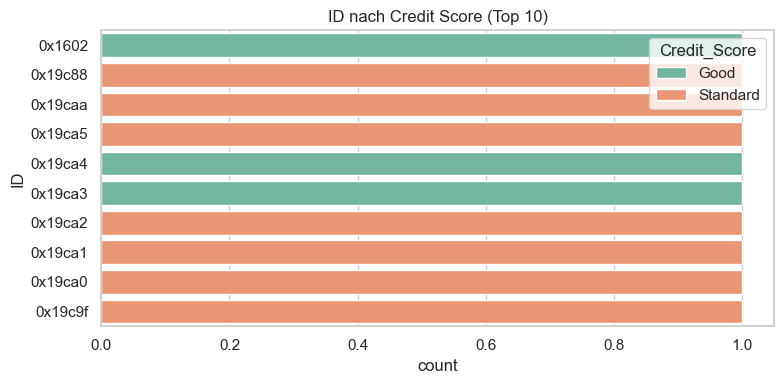

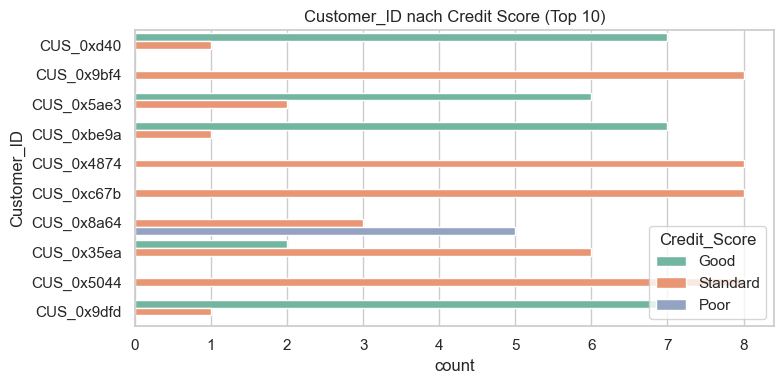

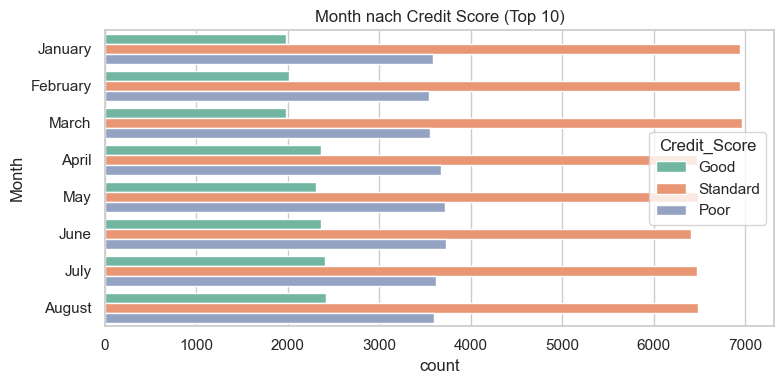

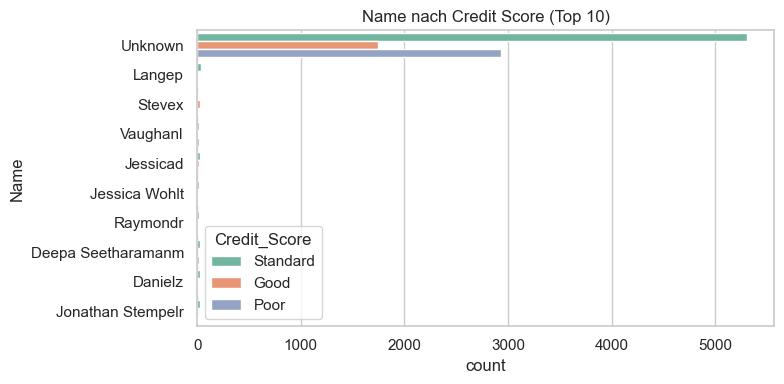

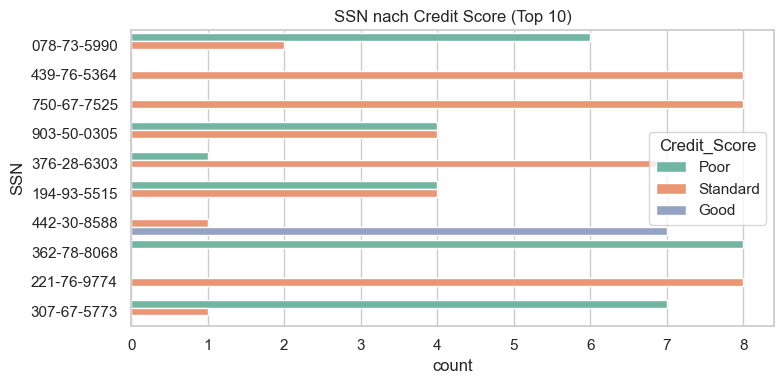

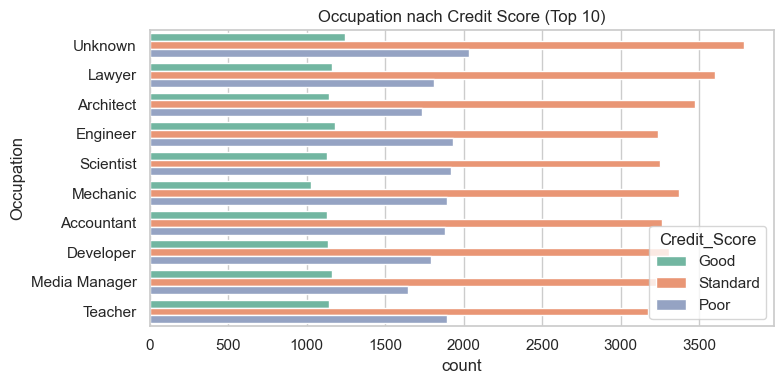

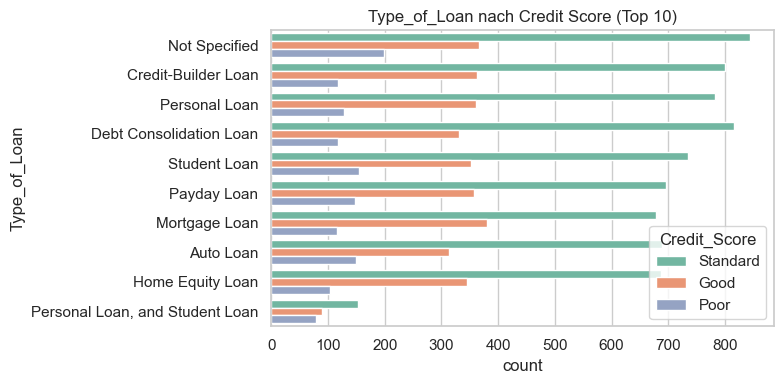

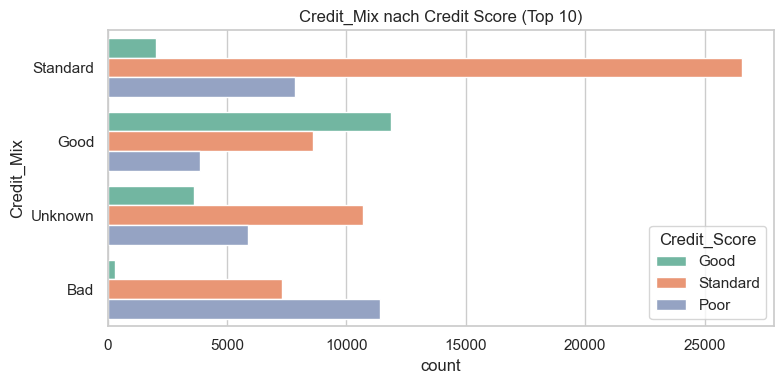

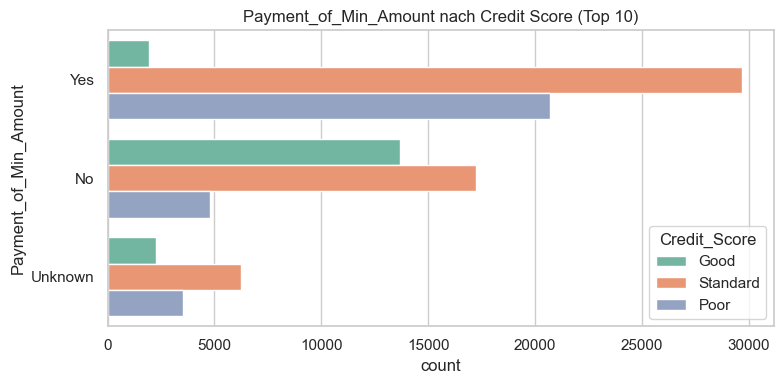

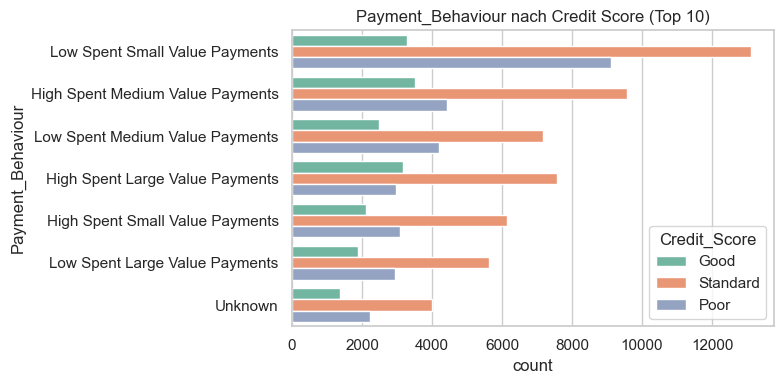

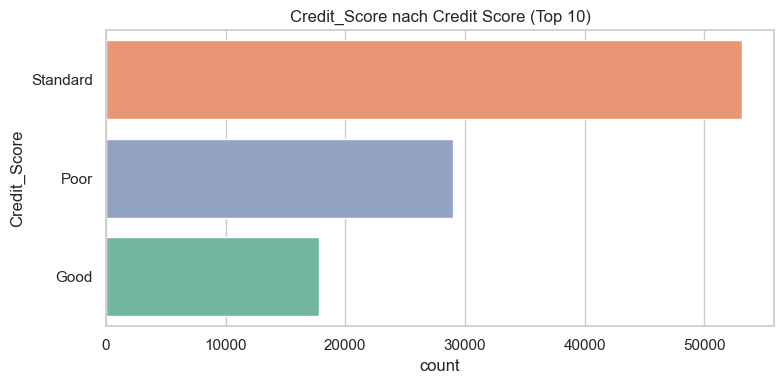

In [20]:
def plot_categorical_by_score(df, column, top_n=10):
    order = df[column].value_counts().head(top_n).index
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df[df[column].isin(order)], y=column, hue='Credit_Score', order=order, palette='Set2')
    plt.title(f'{column} nach Credit Score (Top {top_n})')
    plt.tight_layout()

for col in categorical_cols:
    plot_categorical_by_score(train, col)

## 🔟 Korrelationsanalyse (numerisch)

Das Mapping der Zielvariable auf eine Ordinalskala (Poor=0, Standard=1, Good=2) zeigt lineare Zusammenhänge.


In [21]:
score_map = {'Poor': 0, 'Standard': 1, 'Good': 2}
train_no_outliers['Credit_Score_Ordinal'] = train_no_outliers['Credit_Score'].map(score_map)
corr_matrix = train_no_outliers[numeric_cols + ['Credit_Score_Ordinal']].corr()
target_corr = corr_matrix['Credit_Score_Ordinal'].drop('Credit_Score_Ordinal').sort_values(ascending=False)
target_corr.to_frame('Korrelationskoeffizient')

,Korrelationskoeffizient
Credit_History_Age,0.31
Monthly_Balance,0.20
Age,0.15
Annual_Income,0.13
Monthly_Inhand_Salary,0.13
Amount_invested_monthly,0.06
Credit_Utilization_Ratio,0.03
Total_EMI_per_month,-0.11
Changed_Credit_Limit,-0.15
Num_Credit_Card,-0.28


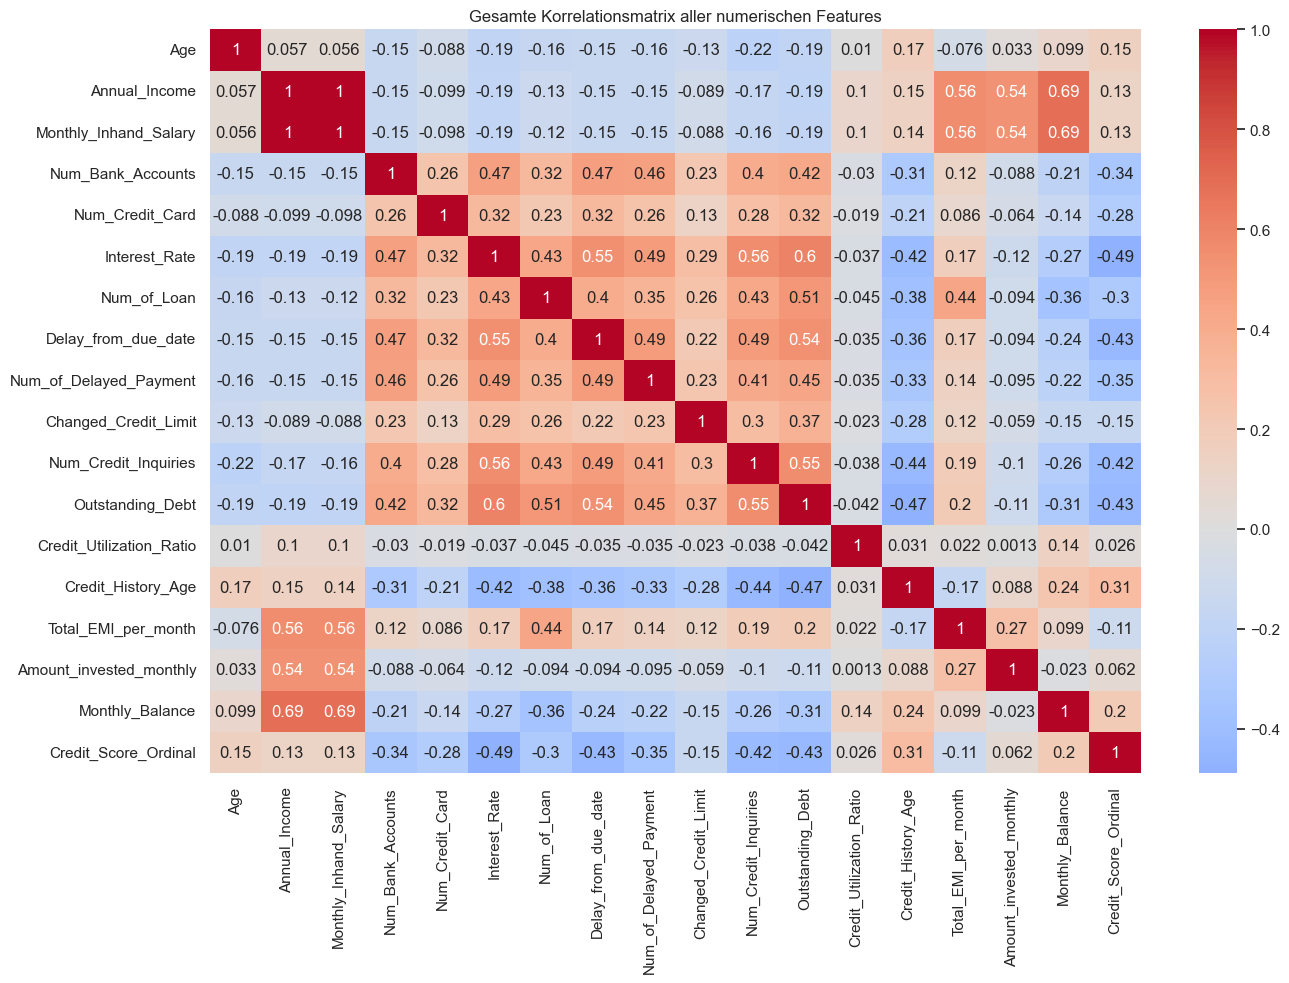

In [22]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Gesamte Korrelationsmatrix aller numerischen Features')
plt.tight_layout()
plt.show()

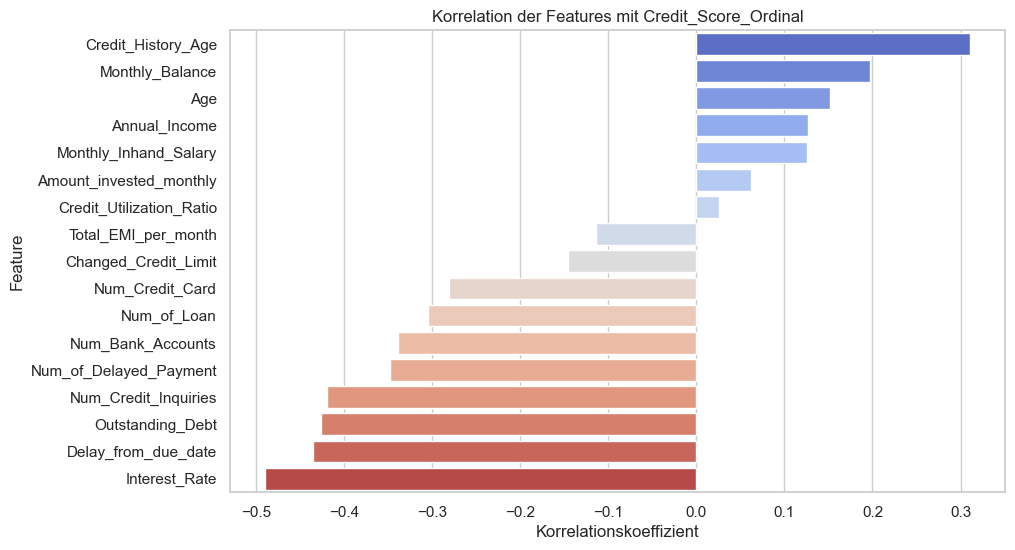

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    hue=target_corr.index,
    palette='coolwarm',
    legend=False
)
plt.title('Korrelation der Features mit Credit_Score_Ordinal')
plt.xlabel('Korrelationskoeffizient')
plt.ylabel('Feature')
plt.show()

## 1️⃣1️⃣ Beziehungen zwischen Schlüsselmerkmalen

Ein Pairplot über eine Stichprobe veranschaulicht Interaktionen zwischen wichtigen Finanzgrößen.


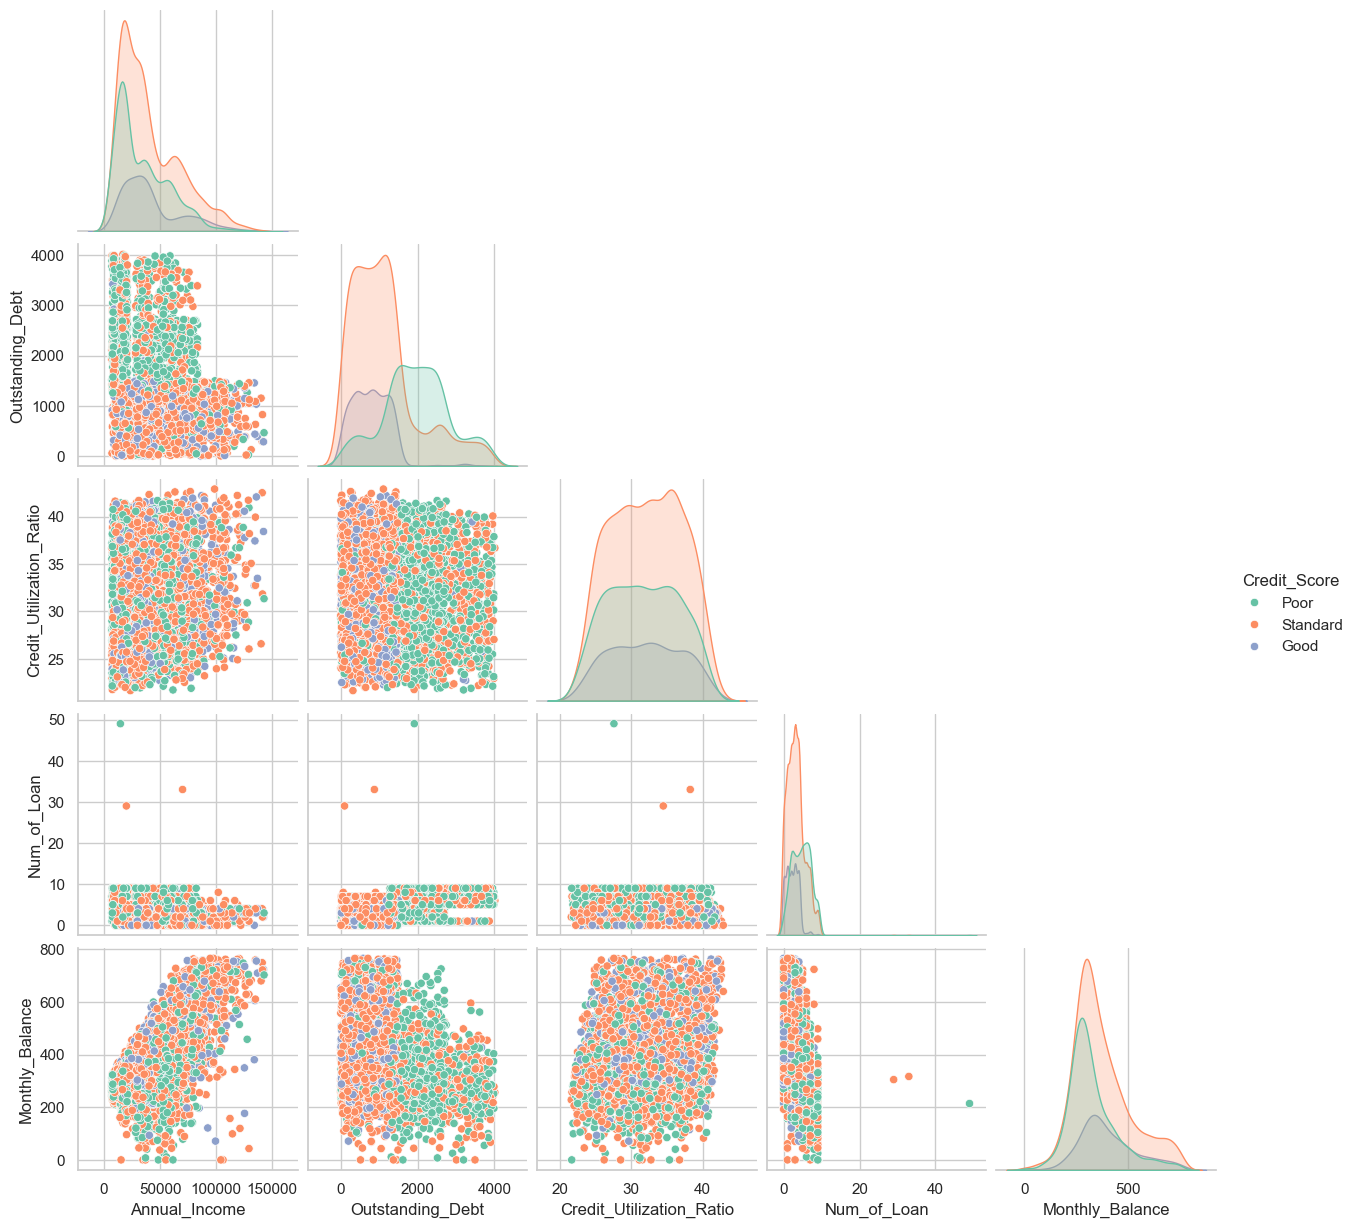

In [24]:
pairplot_features = ['Annual_Income', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Num_of_Loan', 'Monthly_Balance', 'Credit_Score']
sample_df = train_no_outliers[pairplot_features].sample(5000, random_state=42)
sns.pairplot(sample_df, hue='Credit_Score', diag_kind='kde', corner=True, palette='Set2')
plt.show()

## 1️⃣2️⃣ Erkenntnisse und Implikationen

- `Outstanding_Debt`, `Credit_Utilization_Ratio` und `Num_of_Loan` weisen die stärksten numerischen Effekte auf die Zielvariable auf. Das spricht für Modelle, die Verschuldungs- und Auslastungsgrade klar interpretieren können.
- Zahlungsdisziplin (`Payment_of_Min_Amount`, `Payment_Behaviour`) zeigt die höchste kategoriale Trennschärfe. Diese Features sollten als priorisierte Eingaben in klassischen ML-Modellen erscheinen und liefern Interpretierbarkeit über Entscheidungsregeln.
- Die IQR-Analyse identifiziert einen signifikanten Anteil Extrema bei Einkommen und Kreditnutzung; für lineare Baselines empfiehlt sich Training auf der Ausreißer-bereinigten Variante.
- Die Korrelationsmatrix deutet moderate lineare Zusammenhänge an; klassische Modelle mit Feature Engineering (z. B. Gradient Boosting, XGBoost) sind daher vielversprechend. Generative Modelle müssten strukturelle Abhängigkeiten lernen, die hier nur schwach linear ausgeprägt sind – eine Hypothese zugunsten von H1 und H2.
- Für weitere Schritte empfiehlt sich die Nutzung der Effektgrößen als Feature-Priorisierung sowie Tests mit Baselines (Logistic Regression, Random Forest) gegenüber DeepTabular-Varianten.


### Nächste Schritte
1. Feature-Engineering (z. B. Anzahl Kreditarten aus `Type_of_Loan`, Zeitmerkmale aus `Month`).
2. Vergleich klassischer Modelle (LogReg, Random Forest, XGBoost) auf dem bereinigten Datensatz.
3. Entwicklung eines DeepTabular/Generative-Modells (z. B. TabTransformer) auf denselben Features zur empirischen Prüfung von H1/H2.
